# Houston PM 2.5
The data for this was pulled from NASA's MERRA-2 dta products.

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import geopandas
import pyproj
import rasterio
from rasterio.plot import show as rioshow

In [81]:
with xr.open_dataset('data/MERRA-2/merged.nc4') as ds:
    ds.load()
df = ds.to_dataframe()
df.index.set_names(['lat', 'lon', 'Date'], inplace=True)
df

SSSMASS25  DUSCATAU  BCSCATAU  DUEXTTAU   BCFLUXU  \
lat  lon     Date                                                               
27.5 -97.500 2015-01-01  1.929910e-09  0.001560  0.002431  0.001664  0.000004   
             2015-01-02  1.398983e-09  0.001476  0.003116  0.001572  0.000006   
             2015-01-03  7.728337e-10  0.001717  0.002361  0.001830  0.000009   
             2015-01-04  9.810147e-10  0.005071  0.001328  0.005431  0.000006   
             2015-01-05  3.119860e-09  0.002209  0.001528  0.002350  0.000003   
...                               ...       ...       ...       ...       ...   
32.5 -91.875 2020-12-27  1.103539e-09  0.004158  0.001017  0.004435  0.000005   
             2020-12-28  1.144227e-09  0.005018  0.001723  0.005368  0.000007   
             2020-12-29  4.230147e-10  0.003823  0.001744  0.004084  0.000004   
             2020-12-30  2.255502e-09  0.001949  0.001303  0.002082  0.000006   
             2020-12-31  3.794760e-09  0.001723  0.002165  0.001838  0.000006   

                              OCFLUXV  BCANGSTR   SUFLUXV       SSSMASS  \
lat  lon     Date                                                         
27.5 -97.500 2015-01-01  2.109124e-05  1.539294  0.000007  1.594830e-08   
             2015-01-02  5.719697e-05  1.497134  0.000081  6.315156e-09   
             2015-01-03  5.083041e-05  1.462451  0.000108  3.319087e-09   
             2015-01-04  9.259511e-06  1.428846 -0.000008  5.571303e-09   
             2015-01-05  1.278824e-05  1.458938  0.000008  2.227582e-08   
...                               ...       ...       ...           ...   
32.5 -91.875 2020-12-27  1.379185e-05  1.413061  0.000008  5.143933e-09   
             2020-12-28  6.057778e-07  1.455695  0.000003  5.762544e-09   
             2020-12-29  1.668398e-05  1.450341  0.000033  1.945764e-09   
             2020-12-30  3.856315e-05  1.450040  0.000039  1.237178e-08   
             2020-12-31  5.511900e-05  1.496634  0.000060  1.803924e-08   

                              OCSMASS  ...            SLP        TQV  \
lat  lon     Date                      ...                             
27.5 -97.500 2015-01-01  1.090845e-09  ...  102362.734375  34.891560   
             2015-01-02  1.088885e-09  ...  101865.828125  33.353931   
             2015-01-03  1.363154e-09  ...  101606.859375  29.238062   
             2015-01-04  1.100944e-09  ...  102456.515625  11.435887   
             2015-01-05  5.114070e-10  ...  103517.070312  15.401300   
...                               ...  ...            ...        ...   
32.5 -91.875 2020-12-27  4.931962e-09  ...  101882.445312  10.195582   
             2020-12-28  1.469971e-09  ...  102224.921875  22.448105   
             2020-12-29  1.648802e-09  ...  102498.039062  19.456648   
             2020-12-30  1.568662e-09  ...  101746.492188  24.896044   
             2020-12-31  1.415541e-09  ...  101416.195312  34.190285   

                              V2M     TROPQ      V10M      U50M      U10M  \
lat  lon     Date                                                           
27.5 -97.500 2015-01-01 -4.906837  0.000014 -6.401117 -1.040568 -0.583242   
             2015-01-02 -2.013163  0.000004 -2.569824  1.499022  1.378516   
             2015-01-03 -1.764241  0.000006 -2.303708  3.865480  3.092033   
             2015-01-04 -3.088592  0.000018 -4.104443  0.783023  0.458247   
             2015-01-05 -3.853312  0.000016 -5.023897 -2.091863 -1.499263   
...                           ...       ...       ...       ...       ...   
32.5 -91.875 2020-12-27  2.922699  0.000005  4.705240  1.296834  0.679608   
             2020-12-28  0.498021  0.000003  0.997802  2.126305  0.939887   
             2020-12-29  0.287038  0.000003  0.354689 -3.888931 -2.404750   
             2020-12-30  2.724511  0.000014  4.223238 -1.892775 -1.171457   
             2020-12-31 -2.022713  0.000013 -2.763136 -3.121873 -2.404983   

                             QV2M        TROPPV     QV10M  

This data spans are large square that contains much of Texas. Let's look at the PM2.5 values of one day. Then, we will pare the data down to only the area surrounding Houston.

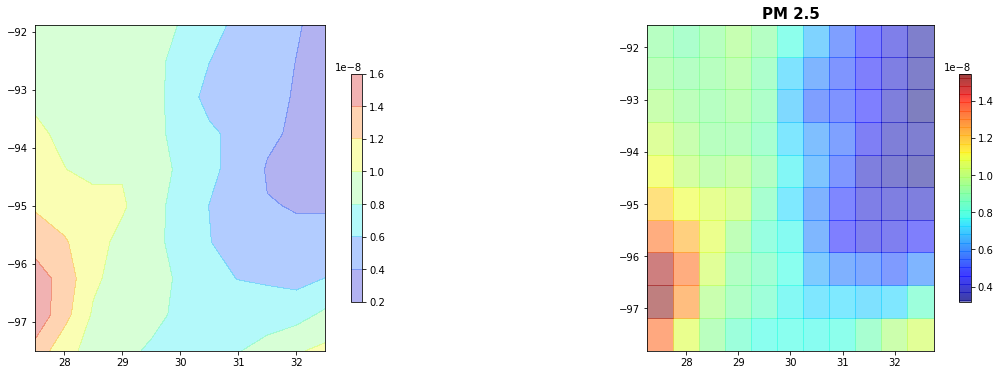

In [82]:
fig, (ax1, ax2) = plt.subplots(1, 2 , figsize=(20,6))

group = df.reset_index(['lat', 'lon']).loc['2015-01-01'].reset_index()
gdf = geopandas.GeoDataFrame(group, geometry=geopandas.points_from_xy(group.lon, group.lat), crs="EPSG:4326")

gdf = gdf[['lat', 'lon', 'PM2.5']]

pivot = gdf.pivot('lon', 'lat')

X=pivot.columns.levels[1].values
Y=pivot.index.values
Z=pivot.values

Xi,Yi = np.meshgrid(X, Y)

color1 = ax1.contourf(Xi, Yi, Z, alpha=0.3, cmap=plt.cm.jet)
color2 = ax2.pcolor(Xi, Yi, Z, shading='auto', alpha=0.5, cmap=plt.cm.jet)

fig.colorbar(color1, ax=ax1, shrink=.7)
fig.colorbar(color2, ax=ax2, shrink=.7)

ax1.set_aspect('equal', adjustable='box')
ax2.set_aspect('equal', adjustable='box')

plt.title(f'PM 2.5', fontsize=15,fontweight='bold')

plt.show();

In [83]:
df = df.reset_index()
north, south, east, west = (30.5, 29, -94.5, -96)
filt = (df['lat'] > south) & (df['lat'] < north) & (df['lon'] > west) & (df['lon'] < east)
df = df[filt]
df = df.set_index(['lat', 'lon', 'Date'])
df

SSSMASS25  DUSCATAU  BCSCATAU  DUEXTTAU   BCFLUXU  \
lat  lon     Date                                                               
29.5 -95.625 2015-01-01  4.533399e-10  0.002021  0.002087  0.002156  0.000004   
             2015-01-02  6.423546e-10  0.001370  0.002210  0.001459  0.000005   
             2015-01-03  5.319692e-10  0.001622  0.003452  0.001729  0.000011   
             2015-01-04  9.017004e-10  0.004917  0.001290  0.005263  0.000008   
             2015-01-05  1.128566e-09  0.001995  0.001070  0.002119  0.000004   
...                               ...       ...       ...       ...       ...   
30.0 -95.000 2020-12-27  2.644830e-09  0.004314  0.000919  0.004610  0.000004   
             2020-12-28  2.339227e-09  0.003801  0.000975  0.004061  0.000004   
             2020-12-29  2.954295e-09  0.002281  0.000758  0.002430  0.000004   
             2020-12-30  5.271861e-09  0.001837  0.000935  0.001960  0.000005   
             2020-12-31  6.721552e-09  0.001791  0.002140  0.001916  0.000006   

                          OCFLUXV  BCANGSTR       SUFLUXV       SSSMASS  \
lat  lon     Date                                                         
29.5 -95.625 2015-01-01  0.000019  1.512882  2.873405e-05  2.579083e-09   
             2015-01-02  0.000035  1.496467  5.385778e-05  2.359006e-09   
             2015-01-03  0.000058  1.491463  1.289998e-04  1.997227e-09   
             2015-01-04  0.000015  1.427629 -7.119951e-06  3.131500e-09   
             2015-01-05  0.000009  1.458390  2.218711e-07  7.439844e-09   
...                           ...       ...           ...           ...   
30.0 -95.000 2020-12-27 -0.000003  1.420772  7.387735e-06  1.482370e-08   
             2020-12-28  0.000005  1.430284  1.209378e-05  1.164618e-08   
             2020-12-29  0.000015  1.418531  2.278212e-05  1.622029e-08   
             2020-12-30  0.000028  1.424324  3.799962e-05  2.575367e-08   
             2020-12-31  0.000099  1.457260  1.162713e-04  2.921010e-08   

                              OCSMASS  ...            SLP        TQV  \
lat  lon     Date                      ...                             
29.5 -95.625 2015-01-01  1.319374e-09  ...  102502.109375  33.872681   
             2015-01-02  1.636088e-09  ...  101835.914062  35.265064   
             2015-01-03  2.193741e-09  ...  101459.898438  35.948349   
             2015-01-04  1.731309e-09  ...  102459.328125   8.960220   
             2015-01-05  8.679905e-10  ...  103588.531250   4.468480   
...                               ...  ...            ...        ...   
30.0 -95.000 2020-12-27  7.764622e-10  ...  101785.757812  17.180527   
             2020-12-28  5.282604e-10  ...  102062.609375  21.724472   
             2020-12-29  5.262817e-10  ...  102127.914062  19.218693   
             2020-12-30  4.267248e-10  ...  101397.546875  25.310759   
             2020-12-31  5.914769e-10  ...  100745.156250  37.198097   

                              V2M     TROPQ      V10M      U50M      U10M  \
lat  lon     Date                                                           
29.5 -95.625 2015-01-01 -2.449461  0.000014 -3.480748 -2.715095 -2.106504   
             2015-01-02 -1.914652  0.000012 -2.711771 -1.203307 -0.913161   
             2015-01-03 -1.075062  0.000006 -1.526446  3.363282  2.576123   
             2015-01-04 -2.824340  0.000018 -4.190116  1.659939  1.085879   
             2015-01-05 -2.647162  0.000015 -3.835776 -1.352524 -0.990397   
...                           ...       ...       ...       ...       ...   
30.0 -95.000 2020-12-27  1.702342  0.000003  3.421182 -2.415095 -1.175590   
             2020-12-28  1.224436  0.000004  2.619898 -2.311006 -1.453111   
             2020-12-29  1.293051  0.000003  2.436874 -6.182795 -3.710495   
             2020-12-30  1.794293  0.000002  3.386426 -4.566867 -2.814300   
             2020-12-31  1.812725  0.000005  3.279339 -4.940825 -3.142035   

                             QV2M        TROPPV     QV10M  

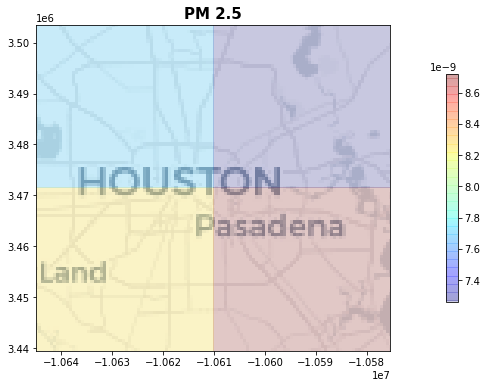

In [84]:
fig, ax = plt.subplots(figsize=(20,6))

group = df.reset_index(['lat', 'lon']).loc['2015-01-01'].reset_index()
gdf = geopandas.GeoDataFrame(group, geometry=geopandas.points_from_xy(group.lon, group.lat), crs="EPSG:4326")
gdf = gdf.to_crs(epsg=3857)

gdf = gdf[['lat', 'lon', 'PM2.5']]
lats = gdf.lat
lons = gdf.lon

transformer = pyproj.Transformer.from_crs("epsg:4326", "epsg:3857")
lats_t, lons_t = transformer.transform(lats, lons)
gdf.lat = lats_t
gdf.lon = lons_t

pivot = gdf.pivot('lon', 'lat')

X=pivot.columns.levels[1].values
Y=pivot.index.values
Z=pivot.values

Xi,Yi = np.meshgrid(X, Y)

c = ax.pcolor(Xi, Yi, Z, shading='auto', alpha=0.2, cmap=plt.cm.jet)

fig.colorbar(c, ax=ax, shrink=.7)

with rasterio.open("houston.tif") as r:
    rioshow(r, ax=ax)

ax.set_aspect('equal', adjustable='box')

ax.set_xlim((np.min(lats_t), np.max(lats_t)))
ax.set_ylim((np.min(lons_t), np.max(lons_t)))

plt.title(f'PM 2.5', fontsize=15,fontweight='bold')

plt.show();

In [85]:
display(df.head())
df.describe()

SSSMASS25  DUSCATAU  BCSCATAU  DUEXTTAU   BCFLUXU  \
lat  lon     Date                                                               
29.5 -95.625 2015-01-01  4.533399e-10  0.002021  0.002087  0.002156  0.000004   
             2015-01-02  6.423546e-10  0.001370  0.002210  0.001459  0.000005   
             2015-01-03  5.319692e-10  0.001622  0.003452  0.001729  0.000011   
             2015-01-04  9.017004e-10  0.004917  0.001290  0.005263  0.000008   
             2015-01-05  1.128566e-09  0.001995  0.001070  0.002119  0.000004   

                          OCFLUXV  BCANGSTR       SUFLUXV       SSSMASS  \
lat  lon     Date                                                         
29.5 -95.625 2015-01-01  0.000019  1.512882  2.873405e-05  2.579083e-09   
             2015-01-02  0.000035  1.496467  5.385778e-05  2.359006e-09   
             2015-01-03  0.000058  1.491463  1.289998e-04  1.997227e-09   
             2015-01-04  0.000015  1.427629 -7.119951e-06  3.131500e-09   
             2015-01-05  0.000009  1.458390  2.218711e-07  7.439844e-09   

                              OCSMASS  ...            SLP        TQV  \
lat  lon     Date                      ...                             
29.5 -95.625 2015-01-01  1.319374e-09  ...  102502.109375  33.872681   
             2015-01-02  1.636088e-09  ...  101835.914062  35.265064   
             2015-01-03  2.193741e-09  ...  101459.898438  35.948349   
             2015-01-04  1.731309e-09  ...  102459.328125   8.960220   
             2015-01-05  8.679905e-10  ...  103588.531250   4.468480   

                              V2M     TROPQ      V10M      U50M      U10M  \
lat  lon     Date                                                           
29.5 -95.625 2015-01-01 -2.449461  0.000014 -3.480748 -2.715095 -2.106504   
             2015-01-02 -1.914652  0.000012 -2.711771 -1.203307 -0.913161   
             2015-01-03 -1.075062  0.000006 -1.526446  3.363282  2.576123   
             2015-01-04 -2.824340  0.000018 -4.190116  1.659939  1.085879   
             2015-01-05 -2.647162  0.000015 -3.835776 -1.352524 -0.990397   

                             QV2M        TROPPV     QV10M  
lat  lon     Date                                          
29.5 -95.625 2015-01-01  0.005170  12385.588867  0.005072  
             2015-01-02  0.006570  11865.560547  0.006467  
             2015-01-03  0.007270  11325.949219  0.007129  
             2015-01-04  0.005313  12323.019531  0.005246  
             2015-01-05  0.003287  13011.084961  0.003148  

[5 rows x 112 columns]

,SSSMASS25,DUSCATAU,BCSCATAU,DUEXTTAU,BCFLUXU,OCFLUXV,BCANGSTR,SUFLUXV,SSSMASS,OCSMASS,...,SLP,TQV,V2M,TROPQ,V10M,U50M,U10M,QV2M,TROPPV,QV10M
count,8.768000e+03,8768.000000,8768.000000,8768.000000,8.768000e+03,8768.000000,8768.000000,8768.000000,8.768000e+03,8.768000e+03,...,8768.000000,8768.000000,8768.000000,8768.000000,8768.000000,8768.000000,8768.000000,8768.000000,8768.000000,8768.000000
mean,4.804019e-09,0.017095,0.002071,0.018242,4.300084e-06,0.000014,1.443080,0.000009,2.421414e-08,2.880524e-09,...,101644.984375,32.013046,0.530144,0.000011,0.861888,-1.177057,-0.790545,0.012958,12992.594727,0.012653
std,5.128774e-09,0.030635,0.001423,0.032630,5.923967e-06,0.000074,0.029746,0.000033,2.639321e-08,3.225033e-09,...,527.719666,13.747928,1.867020,0.000009,2.825848,2.654553,1.800609,0.004778,3117.638184,0.004718
min,1.048483e-11,0.000309,0.000603,0.000327,-4.738612e-05,-0.000651,1.402132,-0.000106,5.327988e-11,2.254478e-10,...,100015.828125,3.730371,-7.510807,0.000002,-9.841187,-14.973824,-11.303222,0.001534,6331.899414,0.001453
25%,1.082839e-09,0.004438,0.001244,0.004742,8.472613e-08,-0.000006,1.419170,-0.000009,5.384370e-09,1.321117e-09,...,101316.095703,20.755805,-0.651665,0.000005,-1.153277,-3.063127,-1.993063,0.009053,10938.776611,0.008806
50%,3.114504e-09,0.008086,0.001679,0.008635,3.599471e-06,0.000006,1.437147,0.000008,1.508555e-08,2.038761e-09,...,101558.972656,33.501787,0.767785,0.000008,1.337072,-1.190459,-0.776268,0.013626,12132.758789,0.013393
75%,6.795575e-09,0.018843,0.002372,0.020117,7.284838e-06,0.000020,1.461278,0.000023,3.409435e-08,3.326562e-09,...,101924.294922,42.648619,1.773365,0.000014,2.899007,0.653717,0.415299,0.017283,14341.666748,0.016914
max,5.138402e-08,0.420442,0.017638,0.447658,4.369943e-05,0.001404,1.558160,0.000247,2.914943e-07,7.147345e-08,...,103971.882812,69.329254,6.818332,0.000159,9.159666,11.069034,9.124202,0.021984,33441.980469,0.021638


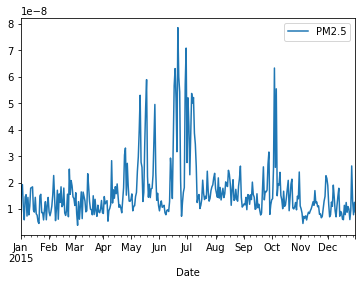

In [86]:
s = df.loc[29.5, -95.625, '2015-01-01':'2015-12-31'].reset_index()[['Date', 'PM2.5']]
s.plot(x='Date');

Now, we have 6 years of data. We will save the data from 2020 for testing and train on the rest of the data.

In [106]:
df

SSSMASS25  DUSCATAU  BCSCATAU  DUEXTTAU   BCFLUXU  \
lat  lon     Date                                                               
29.5 -95.625 2015-01-01  4.533399e-10  0.002021  0.002087  0.002156  0.000004   
             2015-01-02  6.423546e-10  0.001370  0.002210  0.001459  0.000005   
             2015-01-03  5.319692e-10  0.001622  0.003452  0.001729  0.000011   
             2015-01-04  9.017004e-10  0.004917  0.001290  0.005263  0.000008   
             2015-01-05  1.128566e-09  0.001995  0.001070  0.002119  0.000004   
...                               ...       ...       ...       ...       ...   
30.0 -95.000 2020-12-27  2.644830e-09  0.004314  0.000919  0.004610  0.000004   
             2020-12-28  2.339227e-09  0.003801  0.000975  0.004061  0.000004   
             2020-12-29  2.954295e-09  0.002281  0.000758  0.002430  0.000004   
             2020-12-30  5.271861e-09  0.001837  0.000935  0.001960  0.000005   
             2020-12-31  6.721552e-09  0.001791  0.002140  0.001916  0.000006   

                          OCFLUXV  BCANGSTR       SUFLUXV       SSSMASS  \
lat  lon     Date                                                         
29.5 -95.625 2015-01-01  0.000019  1.512882  2.873405e-05  2.579083e-09   
             2015-01-02  0.000035  1.496467  5.385778e-05  2.359006e-09   
             2015-01-03  0.000058  1.491463  1.289998e-04  1.997227e-09   
             2015-01-04  0.000015  1.427629 -7.119951e-06  3.131500e-09   
             2015-01-05  0.000009  1.458390  2.218711e-07  7.439844e-09   
...                           ...       ...           ...           ...   
30.0 -95.000 2020-12-27 -0.000003  1.420772  7.387735e-06  1.482370e-08   
             2020-12-28  0.000005  1.430284  1.209378e-05  1.164618e-08   
             2020-12-29  0.000015  1.418531  2.278212e-05  1.622029e-08   
             2020-12-30  0.000028  1.424324  3.799962e-05  2.575367e-08   
             2020-12-31  0.000099  1.457260  1.162713e-04  2.921010e-08   

                              OCSMASS  ...            SLP        TQV  \
lat  lon     Date                      ...                             
29.5 -95.625 2015-01-01  1.319374e-09  ...  102502.109375  33.872681   
             2015-01-02  1.636088e-09  ...  101835.914062  35.265064   
             2015-01-03  2.193741e-09  ...  101459.898438  35.948349   
             2015-01-04  1.731309e-09  ...  102459.328125   8.960220   
             2015-01-05  8.679905e-10  ...  103588.531250   4.468480   
...                               ...  ...            ...        ...   
30.0 -95.000 2020-12-27  7.764622e-10  ...  101785.757812  17.180527   
             2020-12-28  5.282604e-10  ...  102062.609375  21.724472   
             2020-12-29  5.262817e-10  ...  102127.914062  19.218693   
             2020-12-30  4.267248e-10  ...  101397.546875  25.310759   
             2020-12-31  5.914769e-10  ...  100745.156250  37.198097   

                              V2M     TROPQ      V10M      U50M      U10M  \
lat  lon     Date                                                           
29.5 -95.625 2015-01-01 -2.449461  0.000014 -3.480748 -2.715095 -2.106504   
             2015-01-02 -1.914652  0.000012 -2.711771 -1.203307 -0.913161   
             2015-01-03 -1.075062  0.000006 -1.526446  3.363282  2.576123   
             2015-01-04 -2.824340  0.000018 -4.190116  1.659939  1.085879   
             2015-01-05 -2.647162  0.000015 -3.835776 -1.352524 -0.990397   
...                           ...       ...       ...       ...       ...   
30.0 -95.000 2020-12-27  1.702342  0.000003  3.421182 -2.415095 -1.175590   
             2020-12-28  1.224436  0.000004  2.619898 -2.311006 -1.453111   
             2020-12-29  1.293051  0.000003  2.436874 -6.182795 -3.710495   
             2020-12-30  1.794293  0.000002  3.386426 -4.566867 -2.814300   
             2020-12-31  1.812725  0.000005  3.279339 -4.940825 -3.142035   

                             QV2M        TROPPV     QV10M  

In [169]:
df = df.reset_index()

train_filt = adf['Date'] < '2020-01-01'
test_filt = adf['Date'] > '2019-12-31'

train = df[train_filt]
test = df[test_filt]

df = df.set_index(['lat', 'lon', 'Date'])
display(train)

,lat,lon,Date,SSSMASS25,DUSCATAU,BCSCATAU,DUEXTTAU,BCFLUXU,OCFLUXV,BCANGSTR,...,SLP,TQV,V2M,TROPQ,V10M,U50M,U10M,QV2M,TROPPV,QV10M
0,29.5,-95.625,2015-01-01,4.533399e-10,0.002021,0.002087,0.002156,0.000004,0.000019,1.512882,...,102502.109375,33.872681,-2.449461,0.000014,-3.480748,-2.715095,-2.106504,0.005170,12385.588867,0.005072
1,29.5,-95.625,2015-01-02,6.423546e-10,0.001370,0.002210,0.001459,0.000005,0.000035,1.496467,...,101835.914062,35.265064,-1.914652,0.000012,-2.711771,-1.203307,-0.913161,0.006570,11865.560547,0.006467
2,29.5,-95.625,2015-01-03,5.319692e-10,0.001622,0.003452,0.001729,0.000011,0.000058,1.491463,...,101459.898438,35.948349,-1.075062,0.000006,-1.526446,3.363282,2.576123,0.007270,11325.949219,0.007129
3,29.5,-95.625,2015-01-04,9.017004e-10,0.004917,0.001290,0.005263,0.000008,0.000015,1.427629,...,102459.328125,8.960220,-2.824340,0.000018,-4.190116,1.659939,1.085879,0.005313,12323.019531,0.005246
4,29.5,-95.625,2015-01-05,1.128566e-09,0.001995,0.001070,0.002119,0.000004,0.000009,1.458390,...,103588.531250,4.468480,-2.647162,0.000015,-3.835776,-1.352524,-0.990397,0.003287,13011.084961,0.003148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8397,30.0,-95.000,2019-12-27,7.382859e-10,0.001824,0.001288,0.001945,0.000003,0.000014,1.446103,...,101798.367188,22.611849,0.281974,0.000017,0.595089,-3.374161,-1.941880,0.009877,15260.861328,0.009749
8398,30.0,-95.000,2019-12-28,1.047435e-09,0.001230,0.001167,0.001311,0.000004,0.000029,1.460357,...,101186.671875,33.345982,1.597403,0.000015,3.027991,-3.991869,-2.189558,0.012351,14747.486328,0.012309
8399,30.0,-95.000,2019-12-29,2.354526e-09,0.004388,0.001399,0.004729,0.000007,0.000026,1.481993,...,100845.296875,33.176529,0.568140,0.000034,0.974060,2.750433,1.689226,0.011685,16669.802734,0.011597
8400,30.0,-95.000,2019-12-30,3.740913e-10,0.007175,0.000868,0.007686,0.000009,0.000003,1.402589,...,101881.031250,6.611993,-1.192074,0.000013,-2.458483,3.200467,1.736222,0.004265,12679.042969,0.004034


Now, the columns we want are these:
 - Surface pressure (PS)
 - 2- and 10-meter specific humidity (QV10M, QV2M)
 - 2- and 10-meter air temperature (T10M, T2M)
 - 2-, 10-, and 50-meter wind components (U10M, U2M, V10M, V2M, U50M, V50M)
 - Total precipitable liquid water (TQL)
 - Total precipitable ice water (TQI)
 - Total precipitable water vapor (TQV)
 - Surface albedo (ALBEDO)
 - Total cloud area fraction (CLDTOT)
 - Surface absorbed longwave radiation (LWGAB)
 - Longwave flux emitted from surface (LWGEM)
 - Surface incoming shortwave flux (SWGDN)
 - PM2.5 (PM2.5)
 - Aerosol Optical Depth Analysis (AODANA)

In [170]:
# features = ['PS', 'QV10M', 'QV2M', 'T10M', 'T2M', 'U10M', 'U2M', 'V10M', 'V2M', 'U50M', 'V50M', 'TQL', 'TQI', 'TQV', 'ALBEDO', 'CLDTOT', 'LWGAB', 'LWGEM', 'SWGDN', 'PM2.5', 'AODANA', 'Date', 'lat', 'lon']
features = ['PS', 'QV2M', 'T2M', 'U2M', 'V2M', 'TQL', 'TQI', 'TQV', 'ALBEDO', 'CLDTOT', 'LWGAB', 'LWGEM', 'SWGDN', 'PM2.5', 'AODANA', 'Date', 'lat', 'lon']
train = train[features]
test = test[features]
display(train.head(2))

,PS,QV2M,T2M,U2M,V2M,TQL,TQI,TQV,ALBEDO,CLDTOT,LWGAB,LWGEM,SWGDN,PM2.5,AODANA,Date,lat,lon
0,102206.734375,0.00517,279.765778,-1.503023,-2.449461,0.178650,0.027982,33.872681,0.142819,0.964355,323.165741,342.105408,55.840008,8.259367e-09,0.140065,2015-01-01,29.5,-95.625
1,101544.734375,0.00657,282.227631,-0.656459,-1.914652,0.174095,0.043295,35.265064,0.149256,0.932393,336.696869,355.167114,70.535767,1.758511e-08,0.206579,2015-01-02,29.5,-95.625


(29.5, -95.625)


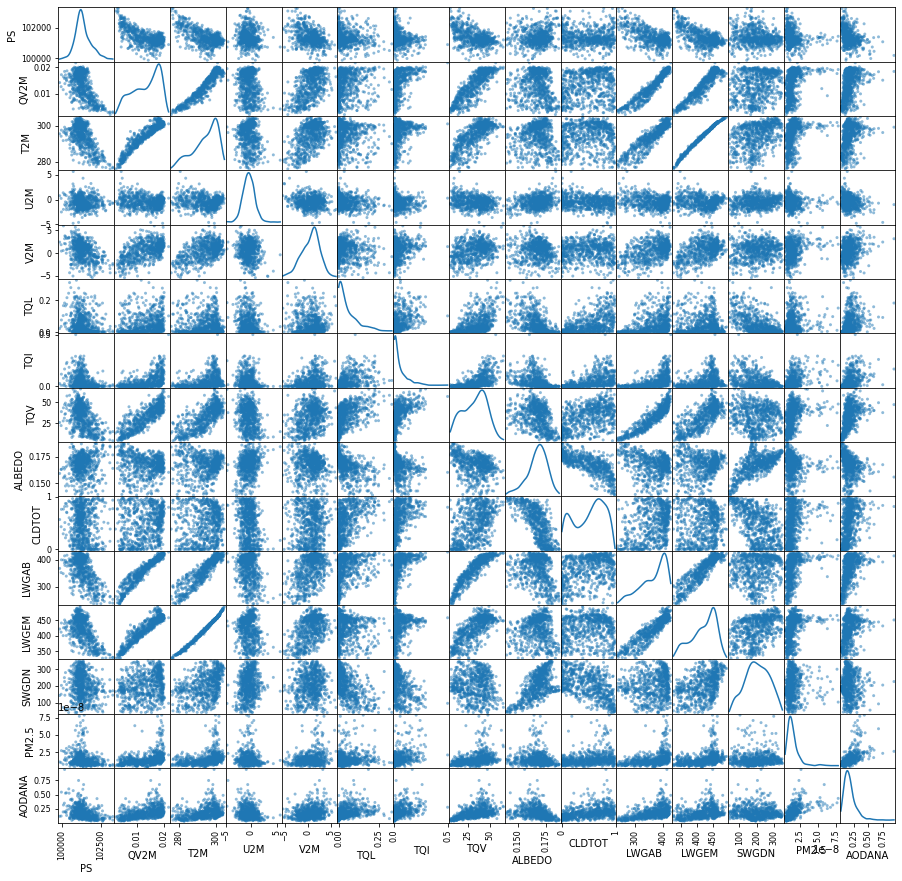

In [172]:
from pandas.plotting import scatter_matrix

for group_name, _df in train.groupby(['lat', 'lon']):
    print(group_name)
    _df = _df.loc[:, ~_df.columns.isin(['lat', 'lon'])]
    _df = _df[_df['Date'] < '2016-12-31']
    scatter_matrix(_df, alpha=.5, figsize=(15, 15), diagonal='kde')
    break

In [50]:
def time_series(start, end, df, columns, lat, lon, xlabel = None, ylabel=None, title= None):
    with plt.style.context('seaborn'):
        colmumns = columns.append('Date')
        _df = df.loc[lat, lon, start:end].reset_index()[columns]
        _df.plot(x='Date')
        plt.xticks(rotation=45)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
    return plt.show();

def make_cyclical(df, features):
    """ For each feature, convert to a cyclical feature.
    
    This is done by mapping the values to a unit circle.
    The entire range of a feature is shifted down to zero. This is done
    by finding the minimum and subtracting that value from each value in the
    feature column. Then, two columns are added for each feature will be named `feature_cos`, and `feature_sin.
    The feature column will be dropped.
    """
    for feature in features:
        if feature in df.columns.values:
            feature_max = max(df[feature].unique())
            feature_min = min(df[feature].unique())
            df[f'{feature}_cos'] = np.cos(df[feature] - feature_min * 2 * np.pi / feature_max)
            df[f'{feature}_sin'] = np.sin(df[feature] - feature_min * 2 * np.pi / feature_max)
            df = df.drop([feature], axis=1)
        
    return df

In [ ]:
def make_model(df, column_to_predict, drop_predictor_column = True, flags = None, test_size = .3, kwargs_collection = None):
    models = ModelCollection(flags)
    copy = df.copy(deep=True)
    copy = copy.drop(['Date'], axis=1)
        
    y = copy[column_to_predict]
    models.set_data(column_to_predict, x, y, test_size = test_size)
    
    if kwargs_collection is not None:
        for model_type, kwargs in kwargs_collection.items():
            models.set_kwarg(model_type, **kwargs)
            
    return models

def evaluate_model(models, site_id, flags = None):
    results = pd.DataFrame({'Site' : [], 'Variable' : [], 'R^2' : [], 'RMSE' : [], 'Method' : []})
    sites = []
    variables = []
    r2 = []
    rmse = []
    methods = []
    site_name = manager.site_id_to_name(site_id)
    for model_type in ModelTypes:
        if flags is None:
            result = models.get_result(model_type)
            sites.append(site_name)
            variables.append(models.predicted_variable)
            r2.append(result['r2'])
            rmse.append(result['rmse'])
            methods.append(model_type.name)
        else:
            if model_type & flags:
                result = models.get_result(model_type)
                sites.append(site_name)
                variables.append(models.predicted_variable)
                r2.append(result['r2'])
                rmse.append(result['rmse'])
                methods.append(model_type.name)
    results = pd.DataFrame({'Site' : sites, 'Variable' : variables, 'R^2' : r2, 'RMSE' : rmse, 'Method' : methods})
    results.set_index(['Site', 'Variable', 'Method'], inplace=True)
    return results

def importance_plots(models, site_id):
    for model_type in [ModelTypes.RandomForestRegressor, ModelTypes.ExtraTreesRegressor, ModelTypes.AdaBoostRegressor, ModelTypes.XGBRegressor]:
        features = models.x_test.columns.values
        importances = models.models[model_type].feature_importances_
        indices = np.argsort(importances)
        plt.suptitle(f'Feature Importances for {models.predicted_variable} at {manager.site_id_to_name(site_id)} for model {model_type.name}')
        plt.barh(range(len(indices)), importances[indices], color='b', align='center')
        plt.yticks(range(len(indices)), features[indices])
#         plt.gca().tick_params(axis='y', labelsize=10)
        plt.xlabel('Relative Importance')
        plt.tight_layout() 
        plt.show()

In [ ]:
all_sites_results = pd.concat(all_sites_results)
all_sites_results.set_index(['Site', 'Variable', 'Method'], inplace=True)
display(all_sites_results)

In [ ]:
dp_all_pms_models = {}
dp_all_pms_results = []
for pm_column in manager.pm_codes:
    if pm_column not in df.columns.values:
        continue   
    copy = drop_other_pm_columns_and_interpolate(df, pm_column)
    
    model = make_model(copy, pm_column, site_id=houston_deer_park_site_code, 
                            n_last=5, 
                            test_size=.2)
    results = evaluate_model(model, houston_deer_park_site_code)
    dp_all_pms_models[pm_column] = model
    dp_all_pms_results.append(results.reset_index())
dp_all_pms_results = pd.concat(dp_all_pms_results)
dp_all_pms_results.set_index(['Site', 'Variable', 'Method'], inplace=True)
display(dp_all_pms_results)

In [ ]:
for _, model in dp_all_pms_models.items():
    importance_plots(model, houston_deer_park_site_code)

In [ ]:
flags = ModelTypes.RandomForestRegressor | \
    ModelTypes.ExtraTreesRegressor | \
    ModelTypes.AdaBoostRegressor | \
    ModelTypes.XGBRegressor
pm_aqi_column = 88502

In [ ]:
models_pm_predictor = make_model(acceptable_pm_df, pm_aqi_column, site_id=houston_deer_park_site_code,
                            flags=flags, 
                            drop_predictor_column=False,
                            n_last=1, 
                            test_size=.5)
results_pm_predictor = evaluate_model(models_pm_predictor, houston_deer_park_site_code, flags)
display(results_pm_predictor)
importance_plots(models_pm_predictor, houston_deer_park_site_code)